### **本节介绍CNN（卷积神经网络）的实现**

我们已经实现了卷积层和池化层，现在来组合这些层，搭建进行手写数字识别的CNN。  
这里要实现如图7-23所示的CNN。

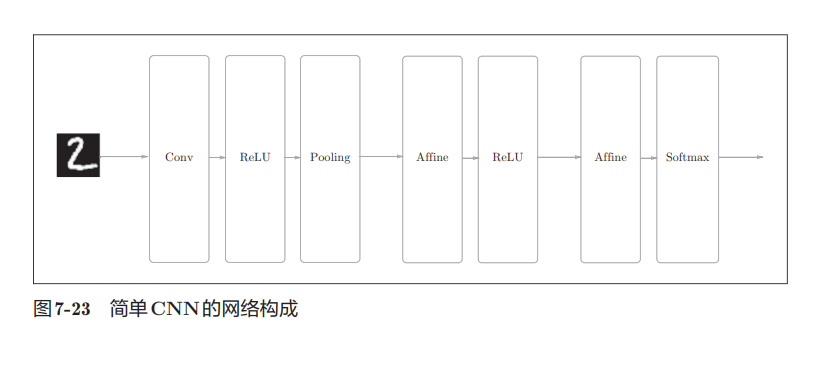

In [1]:
# 导入包及框架
import numpy as np
import matplotlib.pyplot as plt
import my_frame as mf
from collections import OrderedDict # 有序字典

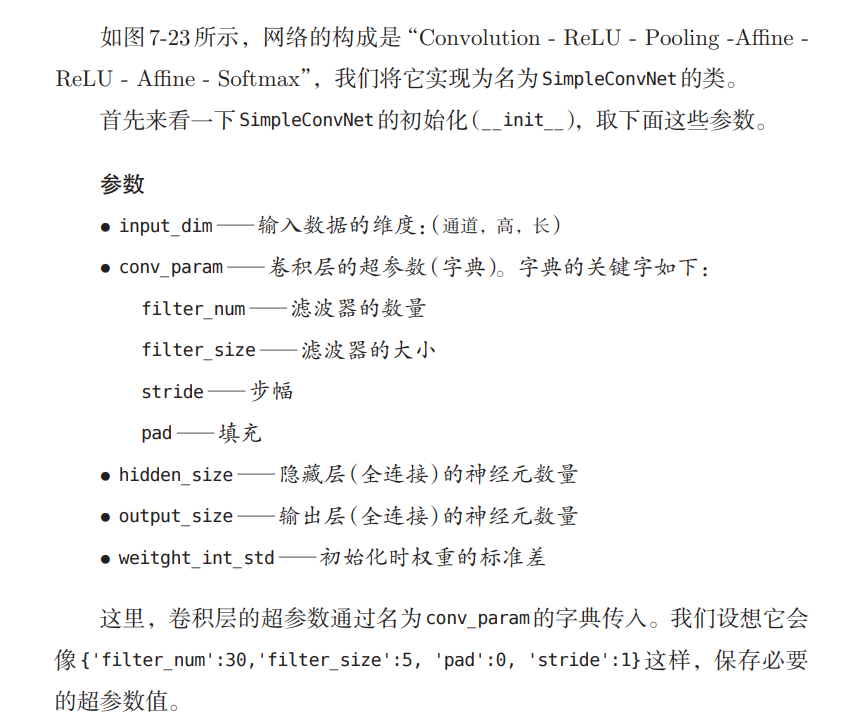

In [2]:
# 定义一个简单的卷积神经网络（滤波器及图像有对此性，即n x n）(且仅有第一层为卷积层，其余为全连接层)
class SimpleConvNet:
    """简单的CNN实现"""
    def __init__(self,input_dim = (1,28,28),
                 conv_param = {'filter_num':30,'filter_size':5,'stride':1,'pad':0},
                 hidden_size = 100,output_size = 10,weight_init_std = 0.01):
        # 获取滤波器属性，便于后面使用
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_stride = conv_param['stride']
        filter_pad = conv_param['pad']

        # 计算输入，输出大小，便于后面使用
        input_size = input_dim[1]
        conv_output_size = int((input_size - filter_size + 2*filter_pad)/(filter_stride) + 1)
        pool_output_size = int(filter_num * (conv_output_size/2)*(conv_output_size/2))

        # 初始化滤波器，即权重矩阵
        self.params = {}
        self.params['W1'] = weight_init_std*np.random.randn(filter_num,input_dim[0],filter_size,filter_size) # 通道与输入数据保持一致
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std*np.random.randn(pool_output_size,hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std*np.random.randn(hidden_size,output_size)
        self.params['b3'] = np.zeros(output_size)

        # 搭建神经网络的计算层
        self.layers = OrderedDict()
        self.layers['Conv1'] = mf.Convolution(self.params['W1'],self.params['b1'],
                                              conv_param['stride'],conv_param['pad'])
        self.layers['Relu1'] = mf.Relu()
        self.layers['Pool1'] = mf.Pooling(pool_h = 2,pool_w = 2,stride = 1,pad = 0)
        self.layers['Affine1'] = mf.Affine(self.params['W2'],self.params['b2'])
        self.layers['Relu2'] = mf.Relu()
        self.layers['Affine2'] = mf.Affine(self.params['W3'],self.params['b3'])
        self.last_layer = mf.SoftmaxWithLoss()

    def predict(self,x):
        """前向传播"""
        for layer in self.layers.values():
            x = layer.forward(x)

        return x
    
    def loss(self,x,t):
        """由输入数据及监督数据计算损失函数"""
        y = self.predict(x)
        return self.last_layer.forward(x,t)
    
    def numerical_gradient(self,x,t):
        """基于数值微分的梯度计算,主要用于确定误差反向传播的正确性;x为输入矩阵,t为监督数据"""

        # 定义兼容函数
        loss_W = lambda W:self.loss(x,t)

        grads = {}
        grads['W1'] = mf.numerical_gradient(loss_W,self.params['W1'])
        grads['b1'] = mf.numerical_gradient(loss_W,self.params['b1'])
        grads['W2'] = mf.numerical_gradient(loss_W,self.params['W2'])
        grads['b2'] = mf.numerical_gradient(loss_W,self.params['b2'])
        grads['W3'] = mf.numerical_gradient(loss_W,self.params['W3'])
        grads['b3'] = mf.numerical_gradient(loss_W,self.params['b3'])

        return grads
    
    def gradient(self,x,t):
        # forward
        self.loss(x,t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 保存梯度
        grads = {}

        grads['W1'] = self.layers['Conv1'].dW
        grads['b1'] = self.layers['Conv1'].db
        grads['W2'] = self.layers['Affine1'].dW
        grads['b2'] = self.layers['Affine1'].db
        grads['W3'] = self.layers['Affine2'].dW
        grads['b3'] = self.layers['Affine2'].db

        return grads        


In [3]:
# 以MNIST数字识别为应用
from mnist import load_mnist

# 读入数据集
(x_train,t_train),(x_test,t_test) = load_mnist(normalize = True,flatten = True,one_hot_label = True)

# 测试误差反向传播计算图的正确性
network = SimpleConvNet()
x_batch = x_train[0:3]
t_batch = t_train[0:3]
batch_size = x_batch.shape[0]
x_batch = x_batch.reshape(batch_size,1,28,-1)


# 分别计算梯度
grads1 = network.gradient(x_batch,t_batch)
grads2 = network.numerical_gradient(x_batch,t_batch)

for key in grads1.keys():
    diff = np.average(np.fabs(grads1[key] - grads2[key]))
    print(key + ":" + str(diff))


ValueError: shapes (3,30,23,23) and (4320,100) not aligned: 23 (dim 3) != 4320 (dim 0)